In [44]:
import pandas as pd
import numpy as np
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
from scipy.stats import f_oneway
from scipy.stats import normaltest
import seaborn as sns
%matplotlib inline

In [2]:
ads_data = pd.read_csv("/mnt/HC_Volume_18315164/home-jupyter/jupyter-an-bogdanov/shared/ads_data.csv.zip")

In [3]:
ads_data.head()

,ad_id,time,event,date,ad_cost_type,has_video,client_union_id,campaign_union_id,platform,ad_cost,target_audience_count,user_id
0,23456,1554076848,view,2019-04-01,CPM,0,5681,23456,android,190.0,125560,793
1,111941,1554135866,view,2019-04-01,CPM,0,111793,111941,ios,215.2,32277,1041
2,111941,1554135866,view,2019-04-01,CPM,0,111793,111941,ios,215.2,32277,41
3,42987,1554135866,view,2019-04-01,CPM,0,28541,42985,ios,199.1,80160,898
4,23456,1554135866,view,2019-04-01,CPM,0,5681,23456,web,190.0,125560,29


In [4]:
df = ads_data.groupby(["ad_id", "ad_cost_type", "platform", "event"], as_index=False) \
    .agg({"user_id" : "count"})

In [9]:
df.head()

,ad_id,ad_cost_type,platform,event,user_id
0,3,CPC,android,click,5
1,3,CPC,android,view,244
2,3,CPC,ios,click,3
3,3,CPC,ios,view,147
4,3,CPC,web,click,1


In [10]:
df = df.pivot(index = ["ad_id", "ad_cost_type", "platform"], columns="event", values="user_id").reset_index()

In [11]:
df

event,ad_id,ad_cost_type,platform,click,view
0,3,CPC,android,5.0,244.0
1,3,CPC,ios,3.0,147.0
2,3,CPC,web,1.0,99.0
3,2132,CPC,android,1.0,55.0
4,2132,CPC,ios,NaN,26.0
...,...,...,...,...,...
1059,122063,CPM,ios,NaN,73.0
1060,122063,CPM,web,NaN,61.0
1061,122086,CPC,android,26.0,1019.0
1062,122086,CPC,ios,16.0,599.0


In [14]:
platform_df = df.groupby(["ad_id", "platform"], as_index=False) \
    .agg({"click" : "sum", "view" : "sum"}).fillna(0)

In [15]:
platform_df

,ad_id,platform,click,view
0,3,android,5.0,244.0
1,3,ios,3.0,147.0
2,3,web,1.0,99.0
3,2132,android,1.0,55.0
4,2132,ios,0.0,26.0
...,...,...,...,...
1059,122063,ios,0.0,73.0
1060,122063,web,0.0,61.0
1061,122086,android,26.0,1019.0
1062,122086,ios,16.0,599.0


In [16]:
platform_df = platform_df.query("view > 100 & click > 0")

In [17]:
platform_df = platform_df.assign(ctr = platform_df.click / platform_df.view)

In [18]:
platform_df["ctr_log"] = np.log(platform_df.ctr)

In [20]:
platform_df

,ad_id,platform,click,view,ctr,ctr_log
0,3,android,5.0,244.0,0.020492,-3.887730
1,3,ios,3.0,147.0,0.020408,-3.891820
6,2276,android,2.0,703.0,0.002845,-5.862210
15,4585,android,17.0,224.0,0.075893,-2.578433
16,4585,ios,24.0,148.0,0.162162,-1.819158
...,...,...,...,...,...,...
1054,121943,web,4.0,348.0,0.011494,-4.465908
1058,122063,android,1.0,126.0,0.007937,-4.836282
1061,122086,android,26.0,1019.0,0.025515,-3.668480
1062,122086,ios,16.0,599.0,0.026711,-3.622673


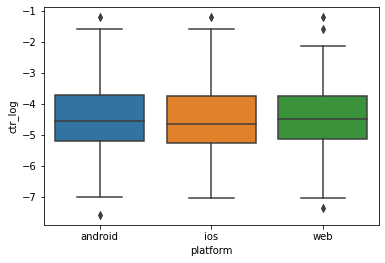

In [21]:
sns.boxplot(x="platform", y="ctr_log", data = platform_df)

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


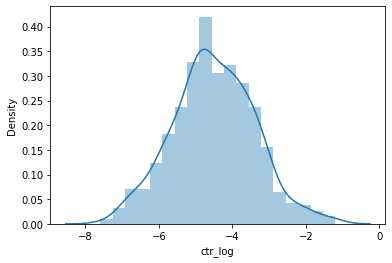

In [24]:
sns.distplot(platform_df.ctr_log)

In [27]:
platform_df.groupby("platform").agg({"ctr" : "median"})

,ctr
platform,
android,0.010695
ios,0.009554
web,0.011213


In [31]:
ttest_ind(platform_df[platform_df.platform == "web"].ctr_log,
         platform_df[platform_df.platform == "android"].ctr_log)

Ttest_indResult(statistic=0.14117870800086754, pvalue=0.8878060153973626)

In [33]:
f_oneway(platform_df[platform_df.platform == "web"].ctr_log,
        platform_df[platform_df.platform == "android"].ctr_log,
        platform_df[platform_df.platform == "ios"].ctr_log)

F_onewayResult(statistic=0.12221144552264535, pvalue=0.884985296331977)

In [99]:
cost_type_df = df.groupby(["ad_id", "ad_cost_type"], as_index=False) \
    .agg({"click" : "sum", "view" : "sum"}).fillna(0)

In [100]:
cost_type_df

,ad_id,ad_cost_type,click,view
0,3,CPC,9.0,490.0
1,2132,CPC,1.0,95.0
2,2276,CPC,2.0,1454.0
3,2475,CPM,0.0,132.0
4,2643,CPM,3.0,286.0
...,...,...,...,...
350,121941,CPM,1.0,640.0
351,121943,CPC,15.0,1722.0
352,122042,CPM,1.0,155.0
353,122063,CPM,1.0,260.0


In [105]:
cost_type_df = cost_type_df.query("view > 100 & click > 0")

In [106]:
cost_type_df = cost_type_df.assign(ctr = cost_type_df.click / cost_type_df.view)

In [114]:
cost_type_df["ctr_log"] = np.log(cost_type_df.ctr)

In [115]:
cost_type_df

,ad_id,ad_cost_type,click,view,ctr,ctr_log
0,3,CPC,9.0,490.0,0.018367,-3.997181
2,2276,CPC,2.0,1454.0,0.001376,-6.588926
4,2643,CPM,3.0,286.0,0.010490,-4.557380
5,4585,CPC,53.0,476.0,0.111345,-2.195126
6,4877,CPC,5.0,2160.0,0.002315,-6.068426
...,...,...,...,...,...,...
350,121941,CPM,1.0,640.0,0.001563,-6.461468
351,121943,CPC,15.0,1722.0,0.008711,-4.743191
352,122042,CPM,1.0,155.0,0.006452,-5.043425
353,122063,CPM,1.0,260.0,0.003846,-5.560682


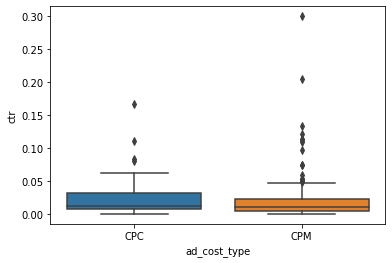

In [116]:
sns.boxplot(x="ad_cost_type", y="ctr", data = cost_type_df)

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


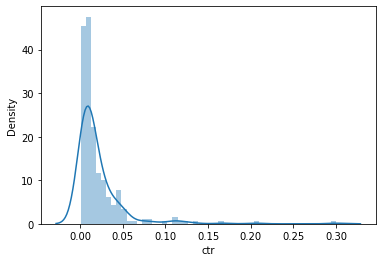

In [117]:
sns.distplot(cost_type_df.ctr)

In [118]:
cost_type_df.groupby("ad_cost_type", as_index=False) \
    .agg( {"ctr" : "median"})

,ad_cost_type,ctr
0,CPC,0.012019
1,CPM,0.010490


In [119]:
cost_type_df.groupby("ad_cost_type", as_index=False) \
    .agg({"ctr" : "mean"})

,ad_cost_type,ctr
0,CPC,0.024107
1,CPM,0.019467


In [69]:
x = [1,10,20,200,2000]
x

[1, 10, 20, 200, 2000]

In [70]:
np.log(x)

array([0.        , 2.30258509, 2.99573227, 5.29831737, 7.60090246])

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


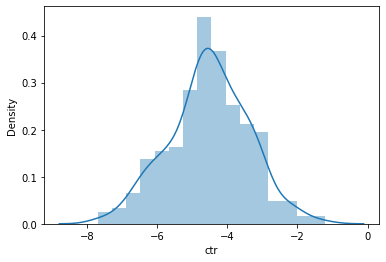

In [120]:
sns.distplot(np.log(cost_type_df.ctr))

In [124]:
cost_type_df[cost_type_df.ad_cost_type == "CPC"].ctr_log

0     -3.997181
2     -6.588926
5     -2.195126
6     -6.068426
7     -3.704823
11    -5.831882
13    -4.018549
14    -4.766438
15    -2.523226
17    -4.884694
19    -6.898715
20    -4.655863
21    -4.139159
25    -3.061386
31    -3.212187
32    -3.459466
34    -3.356746
37    -6.362597
52    -4.897840
54    -4.826712
82    -4.801285
106   -4.525405
117   -5.284218
120   -4.695011
125   -1.787876
151   -4.882802
155   -3.107436
228   -3.791737
245   -4.586242
254   -4.686952
255   -4.881286
256   -3.309630
258   -3.222790
259   -3.530553
266   -5.755215
270   -3.367296
279   -3.672496
284   -2.981276
295   -2.484907
300   -4.337291
301   -4.424847
304   -4.789573
306   -4.382027
321   -3.719651
322   -5.499215
332   -4.465908
333   -3.258097
334   -4.409763
335   -7.006695
336   -4.421247
337   -6.312944
340   -7.013016
348   -2.768245
351   -4.743191
354   -3.688379
Name: ctr_log, dtype: float64

In [125]:
cost_type_df[cost_type_df.ad_cost_type == "CPM"].ctr_log

4     -4.557380
8     -3.751854
9     -4.143135
10    -3.392269
12    -4.727388
         ...   
346   -3.533687
349   -4.424847
350   -6.461468
352   -5.043425
353   -5.560682
Name: ctr_log, Length: 247, dtype: float64

In [126]:
ttest_ind(cost_type_df[cost_type_df.ad_cost_type == "CPM"].ctr_log,
         cost_type_df[cost_type_df.ad_cost_type == "CPC"].ctr_log)

Ttest_indResult(statistic=-1.1407296867039143, pvalue=0.25489224816951805)

In [127]:
ttest_ind(cost_type_df[cost_type_df.ad_cost_type == "CPM"].ctr,
         cost_type_df[cost_type_df.ad_cost_type == "CPC"].ctr)

Ttest_indResult(statistic=-1.0366111047153586, pvalue=0.3007519549674309)

In [34]:
first_ab = pd.read_csv("/mnt/HC_Volume_18315164/home-jupyter/jupyter-an-bogdanov/experiment_lesson_4.csv")

In [35]:
first_ab

,order_id,delivery_time,district,experiment_group
0,3159,44.0,Purlieus,control
1,10426,51.0,Purlieus,control
2,9155,46.0,Purlieus,control
3,10699,34.0,Purlieus,control
4,10061,43.0,Purlieus,control
...,...,...,...,...
20191,14561,42.0,Suburb,test
20192,12015,32.0,Suburb,test
20193,20077,23.0,Purlieus,test
20194,14861,41.0,Central,test


In [36]:
first_ab.experiment_group.value_counts()

test       10104
control    10092
Name: experiment_group, dtype: int64

district
Central     AxesSubplot(0.125,0.125;0.775x0.755)
Purlieus    AxesSubplot(0.125,0.125;0.775x0.755)
Suburb      AxesSubplot(0.125,0.125;0.775x0.755)
Name: delivery_time, dtype: object

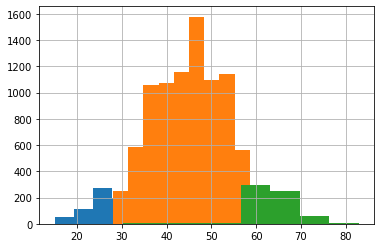

In [42]:
first_ab[first_ab.experiment_group == "control"].groupby("district").delivery_time.hist()

district
Central     AxesSubplot(0.125,0.125;0.775x0.755)
Purlieus    AxesSubplot(0.125,0.125;0.775x0.755)
Suburb      AxesSubplot(0.125,0.125;0.775x0.755)
Name: delivery_time, dtype: object

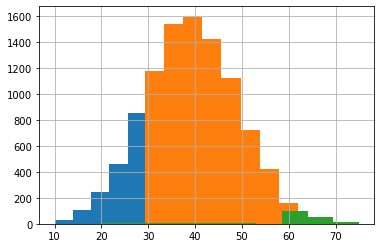

In [43]:
first_ab[first_ab.experiment_group == "test"].groupby("district").delivery_time.hist()

In [47]:
d_test = first_ab[first_ab.experiment_group == "test"].delivery_time
d_control = first_ab[first_ab.experiment_group == "control"].delivery_time

In [46]:
normaltest(d_test)

NormaltestResult(statistic=7.024157092641915, pvalue=0.02983483685333173)

In [48]:
normaltest(d_control)

NormaltestResult(statistic=0.25349755437872584, pvalue=0.8809549607809654)

In [51]:
first_ab[first_ab.experiment_group == "test"].delivery_time.std().round(2)

9.88

In [52]:
first_ab[first_ab.experiment_group == "control"].delivery_time.std().round(2)

9.99

In [54]:
ttest_ind(first_ab[first_ab.experiment_group == "test"].delivery_time, first_ab[first_ab.experiment_group == "control"].delivery_time)

Ttest_indResult(statistic=-43.03582663183714, pvalue=0.0)

In [63]:
round(100 - first_ab[first_ab.experiment_group == "test"].delivery_time.mean() / first_ab[first_ab.experiment_group == "control"].delivery_time.mean() * 100, 2)

13.35